# Feature Selection - DO NOT RUN CODE IN CLASS

For selecting categorical variables, we used financial intuition and also manually/visually checking $Pr(Y|X)$. For the numeric features, we will implement two machine learning based selection methods:

1. Recursive Feature Elimination with Cross-validation
2. Permutation Importance

### Importing Packages

In [1]:
import numpy as np
import pandas as pd

### Reading-In Data

In [2]:
df_default = pd.read_csv("data_processed/01_binary_training.csv")
df_default.head().T

,0,1,2,3,4
funded_amnt,30000.0,7850.0,25000.0,23000.0,12000.0
addr_state,IL,IN,AZ,CO,TX
annual_inc,70000.0,95000.0,115000.0,177000.0,98000.0
application_type,Individual,Individual,Individual,Individual,Individual
dti,22.78,13.97,23.27,13.91,22.3
earliest_cr_line,Apr-1996,Apr-1990,Dec-2001,Aug-2001,Sep-2000
emp_length,< 1 year,4 years,9 years,< 1 year,10+ years
emp_title,Surgical Clinical Reviewer,Technician,VP of Operations,Property Manager,HEAVY DUTY DRIVER
fico_range_high,729.0,679.0,704.0,704.0,699.0
fico_range_low,725.0,675.0,700.0,700.0,695.0


### Isolating Numerical Features

In [3]:
numerical_features = list(df_default.select_dtypes(include=["number", "bool"]).columns)
numerical_features

['funded_amnt',
 'annual_inc',
 'dti',
 'fico_range_high',
 'fico_range_low',
 'id',
 'installment',
 'int_rate',
 'loan_amnt',
 'mort_acc',
 'open_acc',
 'pub_rec',
 'pub_rec_bankruptcies',
 'revol_bal',
 'revol_util',
 'total_acc',
 'last_pymnt_amnt',
 'num_actv_rev_tl',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_old_rev_tl_op',
 'bc_util',
 'bc_open_to_buy',
 'avg_cur_bal',
 'acc_open_past_24mths',
 'charged_off']

In [4]:
df_default = df_default[numerical_features].drop(columns=['id'])

In [5]:
df_default.head().T

,0,1,2,3,4
funded_amnt,30000.0,7850.0,25000.0,23000.0,12000.0
annual_inc,70000.0,95000.0,115000.0,177000.0,98000.0
dti,22.78,13.97,23.27,13.91,22.3
fico_range_high,729.0,679.0,704.0,704.0,699.0
fico_range_low,725.0,675.0,700.0,700.0,695.0
installment,938.85,272.09,573.06,703.78,392.81
int_rate,7.91,14.99,13.33,6.39,10.99
loan_amnt,30000.0,7850.0,25000.0,23000.0,12000.0
mort_acc,0.0,1.0,3.0,2.0,0.0
open_acc,19.0,8.0,12.0,18.0,13.0


Checking the percentage of `charged_off` loans.  The reason I am doing is this is that I `.dropna()` below and I want to make sure that I don't greatly impact the percentage of `charged_off`.

In [6]:
df_default['charged_off'].mean()

0.1998023555985802

Getting rid of `NAs` - this will be handled in a `pipeline` when we do the actual fits.  But this will do for now.

In [7]:
df_default.dropna(inplace=True)
df_default.head().T

,0,1,2,3,4
funded_amnt,30000.0,7850.0,25000.0,23000.0,12000.0
annual_inc,70000.0,95000.0,115000.0,177000.0,98000.0
dti,22.78,13.97,23.27,13.91,22.3
fico_range_high,729.0,679.0,704.0,704.0,699.0
fico_range_low,725.0,675.0,700.0,700.0,695.0
installment,938.85,272.09,573.06,703.78,392.81
int_rate,7.91,14.99,13.33,6.39,10.99
loan_amnt,30000.0,7850.0,25000.0,23000.0,12000.0
mort_acc,0.0,1.0,3.0,2.0,0.0
open_acc,19.0,8.0,12.0,18.0,13.0


Checking the percentage of `charged_off` after `.dropna()` and it looks fine.

In [8]:
df_default['charged_off'].mean()

0.20222850734998213

### Organizing Features and Labels

In [9]:
df_X = df_default.drop(columns=['charged_off'])
df_y = df_default['charged_off']

Creating a hold-out set.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2)

Scaling features.

In [11]:
#from sklearn.preprocessing import scale
mu, std = X_train.mean(), X_train.std()
#X_train_s = scale(X_train)
X_train_s = (X_train - mu) / std
#X_test_s = scale(X_test)
X_test_s = (X_test - mu) / std

## Recursive Feature Elimination with Cross-Validation

The first feature selection method we implement is *recursive feature elimination with cross-validation*.  In this method we start with a model fitted on all the parameters and progressively remove groups of features that have low feature importance, until we find the subset that has the best score.

We begin by importing constructors.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

Next, we instantiate an `RandomForestClassifier` but don't fit it.

In [13]:
# create a random forest model
rf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)

Instantiate a `RFECV` and then `.fit()` it.  Notice I'm using `f1` for scoring. **(6 min to run.)**

In [17]:
%%time
# Recursively eliminate features with cross validation
rfecv = RFECV(estimator=rf, cv=2, scoring='f1', step=5, n_jobs=-1)
rfecv.fit(X_train_s, y_train)
X_new = rfecv.transform(X_train_s)
print("Num Features Before:", X_train_s.shape[1])
print("Num Features After:", X_new.shape[1])

Num Features Before: 23
Num Features After: 3
CPU times: user 1min 7s, sys: 100 ms, total: 1min 7s
Wall time: 1min 46s


First let's see the optimal number of features.

In [18]:
rfecv.n_features_

3

Next, let's examine the results of the recursive feature elimination.

In [19]:
rfecv.cv_results_

{'mean_test_score': array([0.54423124, 0.68969167, 0.68654709, 0.6654563 , 0.67554461,
        0.62315748]),
 'std_test_score': array([0.00027909, 0.00041238, 0.00170384, 0.00039587, 0.00029428,
        0.00102398]),
 'split0_test_score': array([0.54395216, 0.6892793 , 0.68484325, 0.66585218, 0.67525034,
        0.62418146]),
 'split1_test_score': array([0.54451033, 0.69010405, 0.68825093, 0.66506043, 0.67583889,
        0.6221335 ]),
 'n_features': array([ 1,  3,  8, 13, 18, 23])}

Next we focus in on the mean `f1` scores from the successive cross-validations.

In [20]:
rfecv.cv_results_['mean_test_score']

array([0.54423124, 0.68969167, 0.68654709, 0.6654563 , 0.67554461,
       0.62315748])

Examining which features were kept by the feature elimination.

In [21]:
pd.options.display.max_rows = 75
features_kept = pd.DataFrame({'columns': df_X.columns,
                             'Kept': rfecv.support_})
features_kept.sort_values(['Kept', 'columns'], ascending=[False, True])

,columns,Kept
0,funded_amnt,True
6,int_rate,True
15,last_pymnt_amnt,True
22,acc_open_past_24mths,False
1,annual_inc,False
21,avg_cur_bal,False
20,bc_open_to_buy,False
19,bc_util,False
2,dti,False
3,fico_range_high,False


Here we have the ranking of the features.  This is the order in which they have been removed.

The following code cell allows us to view them in a `DataFrame`.

In [22]:
features_ranked = pd.DataFrame({'column': df_X.columns,
                             'ranking': rfecv.ranking_})
features_ranked.sort_values('ranking')

,column,ranking
0,funded_amnt,1
15,last_pymnt_amnt,1
6,int_rate,1
7,loan_amnt,2
5,installment,2
22,acc_open_past_24mths,2
2,dti,2
4,fico_range_low,2
3,fico_range_high,3
8,mort_acc,3


### Permutation Feature Importance

In this section we perform a permuatation feature importance feature selection.  This process starts with a model fitted to all the features.  Then we one by one shuffle each feature which destroys any relationship between the feature and the outcome.  Then we see how the score decreases for each feature.

**Note:** When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important. 

This process begins by fitting a model, we are going to use a `RandomForestClassifier`.

In [23]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train_s, y_train)

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1,
                       random_state=42)

Let's check the out-of-sample accuracy and `f1` by using the test set.

In [24]:
from sklearn.metrics import f1_score
print(model.score(X_test_s, y_test))
print(f1_score(y_test, model.predict(X_test_s)))

0.8738625187931678
0.6342374825862492


Next we run the `permutation_importance` function using the `model` that's been fitted. **(2 min to run.)**

In [25]:
%%time
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_test_s, y_test,
                           n_repeats=30,
                           scoring=['accuracy', 'f1'],
                           random_state=0,
                           n_jobs=-1)

CPU times: user 490 ms, sys: 171 ms, total: 661 ms
Wall time: 33.3 s


Let's view the contents of the output.

In [26]:
r

{'accuracy': {'importances_mean': array([9.54071194e-03, 1.46765691e-04, 6.56583355e-04, 5.28657932e-04,
         6.18902818e-04, 1.05810716e-02, 4.49263157e-02, 5.79206373e-03,
         6.66380295e-04, 3.03328322e-05, 3.61733154e-05, 1.55620617e-04,
         5.54092295e-04, 3.07473181e-04, 5.87816375e-05, 1.10977282e-01,
         2.03474899e-04, 7.31002415e-05, 1.48649718e-04, 2.96169020e-04,
         1.76344913e-04, 5.81033879e-04, 4.18800327e-03]),
  'importances_std': array([3.93565046e-04, 1.23619873e-04, 2.12275989e-04, 2.05680514e-04,
         1.96454861e-04, 4.22509392e-04, 5.52636459e-04, 3.22811438e-04,
         2.00365258e-04, 6.07957101e-05, 3.83231623e-05, 5.06323232e-05,
         1.69483792e-04, 1.08774776e-04, 7.58530827e-05, 5.58244530e-04,
         7.92770199e-05, 1.08415228e-04, 1.20219368e-04, 1.18976855e-04,
         1.80674540e-04, 2.23164868e-04, 3.06845975e-04]),
  'importances': array([[ 8.80028939e-03,  8.87376643e-03,  9.69331811e-03,
           9.72157851e-03

Let's check the `accuracy` based permutation scores.

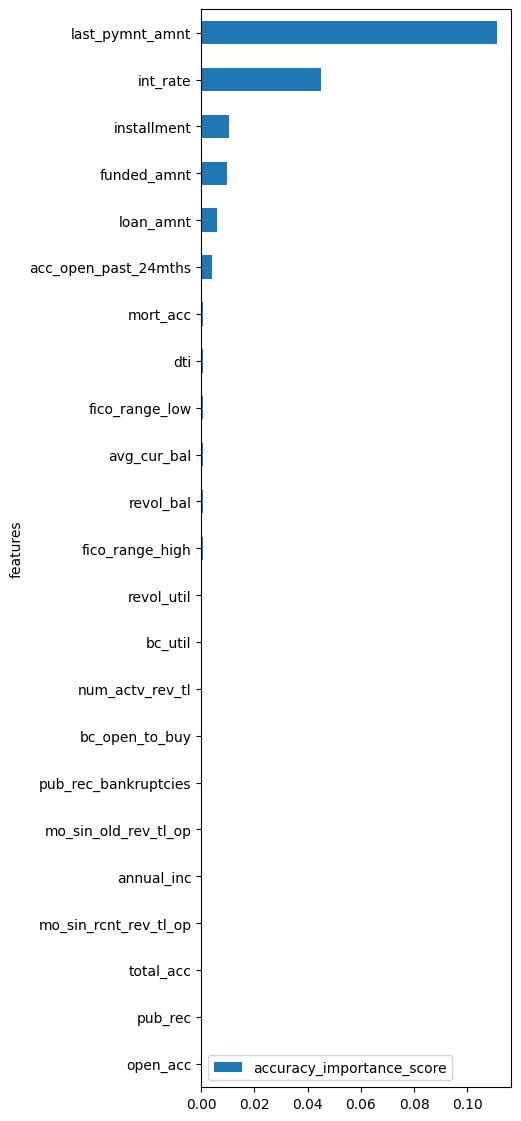

In [27]:
%matplotlib inline
features_ranked_permutation = pd.DataFrame(
    {'features': df_X.columns, 'accuracy_importance_score':r['accuracy']['importances_mean']}
            ).sort_values('accuracy_importance_score', ascending=True)

features_ranked_permutation.plot(kind='barh', x='features', y='accuracy_importance_score',
                                                                     figsize=(4,14));

### Compairing the Two Feature Selection Methods

Let's look at the top 10 features for each selection method.

In [28]:
rfe_top = features_ranked.sort_values('ranking').head(10)

pi_top = features_ranked_permutation.tail(10).sort_values('accuracy_importance_score', ascending=False)

In [29]:
display(rfe_top)
display(pi_top)

,column,ranking
0,funded_amnt,1
15,last_pymnt_amnt,1
6,int_rate,1
7,loan_amnt,2
5,installment,2
22,acc_open_past_24mths,2
2,dti,2
4,fico_range_low,2
3,fico_range_high,3
8,mort_acc,3


,features,accuracy_importance_score
15,last_pymnt_amnt,0.110977
6,int_rate,0.044926
5,installment,0.010581
0,funded_amnt,0.009541
7,loan_amnt,0.005792
22,acc_open_past_24mths,0.004188
8,mort_acc,0.000666
2,dti,0.000657
4,fico_range_low,0.000619
21,avg_cur_bal,0.000581


Now if we do an outer-join on these two `DataFrames` we can see that 9 of them match.

In [30]:
rfe_top.merge(pi_top, how='outer', left_on='column', right_on='features').dropna().reset_index(drop=True)

,column,ranking,features,accuracy_importance_score
0,funded_amnt,1.0,funded_amnt,0.009541
1,last_pymnt_amnt,1.0,last_pymnt_amnt,0.110977
2,int_rate,1.0,int_rate,0.044926
3,loan_amnt,2.0,loan_amnt,0.005792
4,installment,2.0,installment,0.010581
5,acc_open_past_24mths,2.0,acc_open_past_24mths,0.004188
6,dti,2.0,dti,0.000657
7,fico_range_low,2.0,fico_range_low,0.000619
8,mort_acc,3.0,mort_acc,0.000666


## Columns to Keep

In [31]:
numeric_columns_to_keep = [
    "funded_amnt",
    "last_pymnt_amnt",
    "int_rate",
    "loan_amnt",
    "installment",
    "acc_open_past_24mths",
    "dti",
    "fico_range_low",
    "mort_acc",
]